<a href="https://colab.research.google.com/github/PrincetonUniversity/intro_machine_learning/blob/main/day3/Intro_Machine_Learning_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Networks**
Gage DeZoort

Wintersession 2025

Introduction to Machine Learning

*Sections 0 and 1 are adapted by Gage DeZoort and Julian Gold from a tutorial by Savannah Thais. Relevant citations are made in-line.*

*Section 2 is written by Gage DeZoort with updates from Julian Gold. Relevant citations are made in-line.*

# 0. Separating Moons via Logistic Regression

Let's start with a binary classification problem that is difficult to solve with a linear classification boundary - that is, you can't draw a line to separate the classes. This exercise is adapted from [Denny Britz](https://github.com/dennybritz/nn-from-scratch).

## 0.1 Generating the Data
 To do this, we'll use the `scikit-learn` [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function to generate our dataset. In a nutshell, this generates noisey samples from two overlapping half-circles.

### install, import

In [3]:
pip install ipympl

In [4]:
# package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

import io
import gc
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

# display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

### generate the data

In [ ]:
## QUESTION: what happens as you vary noise from 0.2?
X, y = sklearn.datasets.make_moons(n_samples=200, noise=0.2)

# print some dataset properties
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Classes: {np.unique(y)}")

# plot the data
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(12,6))

# first plot the unlabeled data (inputs to the model)
axs[0].scatter(X[:,0], X[:,1], s=10, color="Black", label="Input Data")
axs[0].set_xlabel(r"$x_1$")
axs[0].set_ylabel(r"$x_2$")
axs[0].set_title("Model Inputs")

# next plot the labeled data (which we'll use to train the model)
axs[1].scatter(X[:,0][y==1], X[:,1][y==1], s=10, c="red", label="Shows You Don't Love")
axs[1].scatter(X[:,0][y==0], X[:,1][y==0], s=10, c="blue", label="Shows You Love")
axs[1].legend(loc="best")
axs[1].set_xlabel(r"$x_1$")
axs[1].set_ylabel(r"$x_2$")
axs[1].set_title("Truth Labels")
plt.show()

We've generated a dataset in which two input features $(x_1, x_2)$ are associated to one of two class labels, 0 or 1.

These class labels are drawn as red and blue above. Since this is a toy problem, we can come up with a fun interpretation of the data. Let's say each point represents a Netflix show that you'll either like (blue) or dislike (red).

In this case, $x_1$ and $x_2$ would measure something about each show - quantities like the average user rating or the ratio of dialogue to action. Given $(x_1, x_2)$, how can we predict whether or not you'll like the show?

## 0.2 Linear Classifier
By eye, it looks pretty difficult to separate the data with a linear decision boundary. Let's see what happens when we do:

In [ ]:
# train a logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

In [15]:
# helper function to plot the output of the classifier
def plot_decision_boundary(pred_func):
    # set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # plot the contour and training examples
    fig = plt.figure(dpi=100, figsize=(6,6))
    plt.title("Logistic Regression")
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.coolwarm)
    plt.show()

In [ ]:
# plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))

In [ ]:
# print the accuracy of the classifier
clf.score(X, y)

By eye, the model did something reasonable - however, the linear decision boundary is clearly not appropriate for this problem. The training accuracy (at original noise level `.2`) should be around 85-87%, meaning roughly 13-15 examples from each class are mis-classified. The reason should be clear -- the data is not linearly separable. So can we find a model capable of fitting non-linear trends?

# 1. Neural Networks
We can indeed! Let's implement a neural network (NN). We're going to step through this slowly, starting by implementing a NN by hand. We'll then turn to some modern deep learning libraries like `PyTorch`, `TensorFlow`, and `Keras` and tackle some harder problems.

## 1.1 Neural Networks by Hand
### Overview
Let's start by being precise about the ML task at hand. Our "Netflix" dataset associated 2 input features with a binary classification label:

**Inputs**: $\mathbf{x}_i= \begin{bmatrix} x_{i,1} \\ x_{i,2} \end{bmatrix}$

**Class Labels**: $y_i\in\{0,1\}$

Our goal is to build a NN with one hidden layer that takes input features $\mathbf{x}_i$ and maps them to predictions $\hat{y}_i$.


First, a word about notation: when we say $y_i$ is either 0 or 1, we are using *integer encodings* to describe our truth labels.

This could actually confuse a NN model because the integers may imply some heirarchy between the two labels; after all, 1 is larger than 0!

It's preferable to treat the classes on the same footing and use *one-hot encoding* like so:

$$\begin{align}
  &\text{integer encoding:} \,0 \rightarrow \text{one-hot encoding:} \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
  &\text{integer encoding:} \,1\rightarrow \text{one-hot encoding:} \begin{bmatrix} 0 \\ 1 \end{bmatrix}
\end{align}$$

We'll use one-hot encodings in the following cells, so you should think about the class labels and predictions like this:

**Class Labels**: $\quad\mathbf{y}_i = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$ or $\begin{bmatrix} 0 \\ 1 \end{bmatrix}$

**Predictions (e.g.)** $\quad\hat{\mathbf{y}}_i = \begin{bmatrix} 0.55 \\ 0.45 \end{bmatrix}$ or $\begin{bmatrix} 0.31 \\ 0.69 \end{bmatrix}$

With that in mind, let's start with a picture of the neural network we're going to build:

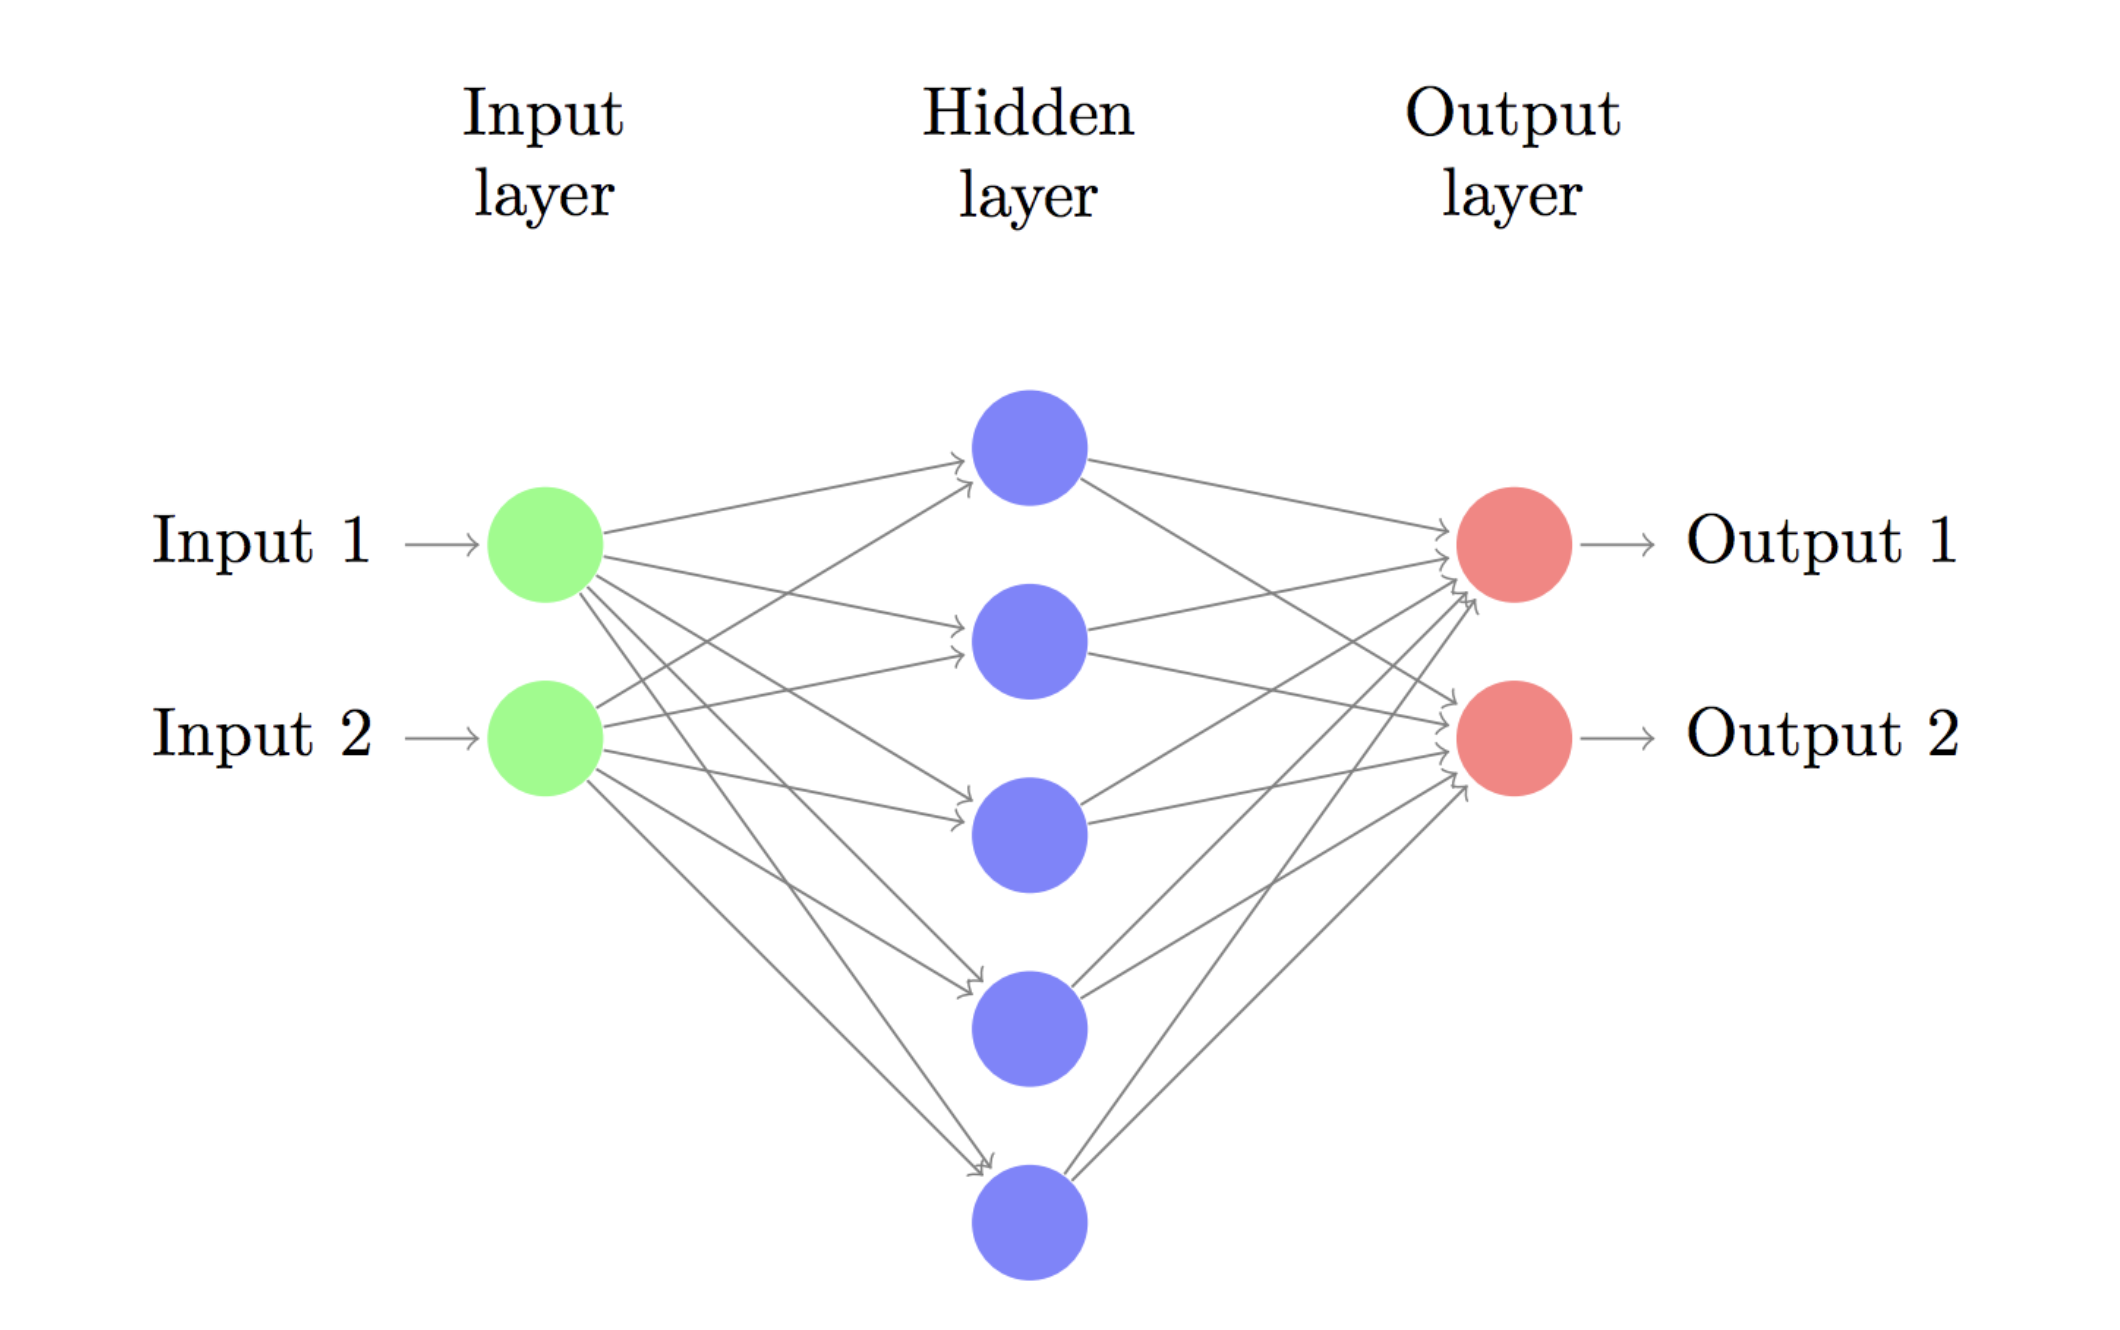

In the diagram above, we see that the network accepts two inputs, creates a hidden representation with 5 dimensions, and then produces 2 output predictions.

The dimensionality of the hidden layer controls the complexity of the model; increasing the size of the hidden layer creates a larger model. Intuitively, larger models should be more _expressive_: capable of modeling a wider class of functions. However, we have to watch out for *overfitting*, wherein a model is large enough that it can "memorize" the training data.

Something important is missing in this diagram: an activation function!

This is where the model's non-linear hypothesis comes into play (remember, a the linear model above had trouble classifying some examples). The values in the hidden layer above have presumably been passed through a function like `sigmoid`, `tanh`, or `ReLU`.

Generically, we'll refer to activation functions as $\sigma(\cdot)$. We'll spend more time on this in the following cells.

Likewise, we want our 2 output fields to correspond to class probabilities so that we can interpret the network's prediction. One way to do this is to apply `Softmax` to the outputs, which normalizes them in a nice way. We'll get into more specifics in just a bit; for now, let's look at some common activation functions:

In [ ]:
# plot some common activation functions
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), dpi=100)
xrange = np.linspace(-10, 10, 1000)

#
# sigmoid
# (not often used, gradients vanish near 0 and 1)
#

axs[0].plot(xrange, 1/(1+np.exp(-xrange)))
axs[0].set_xlabel("x")
axs[0].set_ylabel("sigmoid(x)")

#
# tanh
# (more robust gradients than sigmoid, zero-centered, difficult to compute
#  due to the exponential functions involved )
#

axs[1].plot(xrange, np.tanh(xrange))
axs[1].set_xlabel("x")
axs[1].set_ylabel("tanh(x)")

#
# relu
# (rectified linear unit - easy and fast to compute)
#

axs[2].plot(xrange, np.maximum(xrange, 0))
axs[2].set_xlabel("x")
axs[2].set_ylabel("ReLU(x)")
axs[1].set_title("Common Activation Functions")
plt.tight_layout()
plt.show()

### NN Architecture

Remember, forward propagation is a series of matrix additions and multiplications, so it's important to get the dimensions right. Let's drill down a bit more. Fix an activation function $\sigma(\cdot)$ and consider sets of _weights_ and _biases_ with the following dimensions:

$$ \mathbf{W}_1\in\mathbb{R}^{n_\mathrm{hidden}\,\times\, 2} \qquad \mathbf{b}_1\in\mathbb{R}^{n_\mathrm{hidden}}$$

$$ \mathbf{W}_2\in\mathbb{R}^{2\,\times\, n_\mathrm{hidden}}\qquad \mathbf{b}_2\in\mathbb{R}^{2}$$



The weight matrix $\mathbf{W}_1$ lives on the arrows between input layer and the hidden layer. The bias vector $\mathbf{b}_1$ lives on the nodes of the hidden layer, likewise $\mathbf{W}_2$ the arrows between hidden and output layers. Bias vector $\mathbf{b}_2$ lives on the output layer.

The dimension of the hidden layer is $n_\mathrm{hidden}$; this was 5 in the diagram above, but here we've generalized it.
The weights and biases are very important; these are the *trainable parameters* in your network, i.e. the numbers being adjusted during training.
Here's what our NN model (architecture) should look like:

$$
\begin{align}
  \mathrm{Input}:\ & \mathbf{x}_i\in\mathbb{R}^2 \\
  \mathrm{First\ Preactivations}:\ & \mathbf{z}_1 = \mathbf{W}_1 \mathbf{x}_i + \mathbf{b}_1\\
  \mathrm{Hidden\ Layer}:\ & \sigma( \mathbf{z}_1)\\
  \mathrm{Second\ Preactivations}:\ & \mathbf{z}_2 = \mathbf{W}_2\sigma(\mathbf{z}_1) + \mathbf{b}_2\\
  \mathrm{Output}:\ & \hat{\mathbf{y}}_i = \texttt{Softmax}(\mathbf{z}_2)\in\mathbb{R}^2
  \end{align}
$$


Check that the dimensions work out in our NN above! Here's a helpful exercise:

> **Exercise**: If we take $n_\mathrm{hidden}=500$, how many trainable parameters does the network have? (Answer: 2502).

In [31]:
# EXERCISE


The `Softmax` function normalizes the two raw components of $\mathbf{z}_2$ so that they indicate the likelihood of $\mathbf{x}_i$ being either blue or red (a good or bad Netflix show). For reference, if you have $C$ truth classes (here we have 2), softmax returns a vector of size $C$ with components

$$ \texttt{Softmax}(z)_c = \frac{e^{z_c}}{\sum_{c=1}^C e^{z_c}}$$


**Note:** `ReLU`, `tanh` and `sigmoid` are each functions of a single variable. When used as $\sigma$ and applied to vectors, they act on each coordinate of the vector, applying the same single-variable function to each coordinate. That is,

$$ \text{ReLU}(\mathbf{z}) = \begin{bmatrix}\text{ReLU}(z_1)\\ \text{ReLU}(z_2)\end{bmatrix}$$

In contrast, `Softmax` scales every component of $\mathbf{z}$ in a way that depends on every other component! This is because of the sum in the denominator, the normalization factor $\sum_c e^{z_c}$. These positive entries summing to one can be interpreted as _probabilities_. More specifically, they describe a full _probability distribution_ over the output coordinates.

Changing one cooordinate of $\mathbf{z}$ will change all coordinates of $\texttt{Softmax}(\mathbf{z})$. However: you can check that shifting all coordinates of $\mathbf{x}$ by the _same_ number will _not_ change its softmax.

> **Exercise**: What's the difference between standard normalization and softmax normalization? Try normalizing the vectors [0.5, 1] and [5, 10] with both methods.

In [ ]:
# EXERCISE

from scipy.special import softmax

a = torch.Tensor([0.5, 1]) # standard normalization [0.5 / 1.5, 1 / 1.5] = [0.33, 0.67]

softmax(a)

Okay, time to code up this NN architecture.

We're going to choose $\sigma(\mathbf{z})=\tanh(\mathbf{z})$ in this case because its derivative, $1-\tanh^2(\mathbf{z})$, is something we can calculate immediately from the value of $\tanh(\mathbf{z})$. By the way, this function can be written in terms of exponentials:

$$
\tanh(z) = \frac{e^{z} - e^{-z}}{e^z + e^{-z}}
$$


In building our NN, we have to supply initial values for $\mathbf{W}_1$, $\mathbf{b}_1$, $\mathbf{W}_2$, and $\mathbf{b}_2$. This process is called *initialization* and is important to starting with a trainable NN. More on this after the code.

In [ ]:
# we'll use the following dimensions repeatedly in the following cells:

# we sampled 200 points
n_examples = len(X)

# each of the 200 points has 2 features (x1, x2)
input_dim = X.shape[-1]

# we want to predict class probabilities for 2 classes
output_dim = len(np.unique(y))

print(n_examples, input_dim, output_dim)

In [ ]:
# now let's build the  NN!

class Model():
  def __init__(self, input_dim, hidden_dim, output_dim):
    np.random.seed(0)

    # assign some learnable parameters to the NN (random normal variables)
    # W1 is a 2 x n_hidden matrix
    self.W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
    # b1 is a 1 x n_hidden matrix
    self.b1 = np.zeros((1, hidden_dim))
    # W2 is a n_hidden x 2 matrix
    self.W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
    # b2 is a 1 x 2 matrix
    self.b2 = np.zeros((1, output_dim))

  # given X with dimension 200x2, predict a \hat{y} with dimension 200x2
  def forward_pass(self, X):
    self.z1 = X @ self.W1 + self.b1 # @ is a shorthand for matrix multiplication
    self.h1 = np.tanh(self.z1)
    self.z2 = self.h1 @ self.W2 + self.b2
    self.output = self.softmax(self.z2)
    return self.output

  def softmax(self, z):
    exp_scores = np.exp(z)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return probs

# build a test model with a hidden layer of size 5
model = Model(
    input_dim=input_dim,
    hidden_dim=5,
    output_dim=output_dim,
)

# let's see what the network (randomly initialized) outputs for the first 5 examples
print(X.shape)
model.forward_pass(X)[:5]

Note how we initialize the weights $\mathbf{W}_1$ in terms of the input size and $\mathbf{W}_2$ in terms of hidden layer size. The optimal way to do this will depend on the activation function being used; the heuristics behind these choices aim at preserving the variance of the input signal as it propagates through the network.

As the following cartoon examples suggest, this becomes more important as the number of hidden layers (network depth) increases.

In [ ]:
# cartoon: suppose that the scale of the weights is 1.5 x
# what it "should" be, at each layer:
A = np.array([[1.5, 0], [0, 1.5]])
print(A,"\n\n", A @ A, "\n\n", np.linalg.matrix_power(A, 20))

In [ ]:
# or suppose that the scale of the weights is .75 x
# what it "should" be, at each layer:
B = np.array([[.75, 0], [0, .75]])
print(B,"\n\n", B @ B, "\n\n", np.linalg.matrix_power(B, 20))

## Training the NN



### Loss Function
So now we've defined an NN architecture and we have our data. All that remains is to train the NN - i.e. tune its learnable parameters - to separate our data points.

Our strategy will be to define a *loss function* that the NN will minimize. In doing so, the NN will learn to perform the classification task. Since the output of the NN is fed through `Softmax`, we can interpret each (2-dimensional) $\hat{\mathbf{y}}_i$ as a measure of the likelihood that you'll hate (output 1) or love (output 2) the Netflix show encoded by $\mathbf{x}_i$.



We'll be using the *cross entropy* loss function, which is designed to penalize the network in proportion to how "wrong" it was. For a single input $\mathbf{x}_i$ with truth label $\mathbf{y}_i$, and a NN's prediction $\hat{\mathbf{y}}_i$, the cross entropy loss of the prediction is defined as a sum over the number ($C$) of truth classes:

$$L_i(\mathbf{y}_i, \hat{\mathbf{y}}_i) = -\sum_{c=1}^C y_{i,c}\log\hat{y}_{i,c}$$



Remember, we're using one-hot encodings, so $\mathbf{y}_i$ and $\hat{\mathbf{y}}_i$ are vectors of size $C$. In training the network, we will make a prediction on every input $x_i$, so let's define the total loss as the average over the sample (with arbitrary size $N$):

$$L(\mathbf{y},\hat{\mathbf{y}}) = -\frac{1}{N}\sum_{i=1}^N L_i( \mathbf{y}_i,\hat{\mathbf{y}}_i) = -\frac{1}{N}\sum_{i=1}^N\sum_{c=1}^C y_{i,c}\log\hat{y}_{i,c}$$

The value of $L$ is higher when $y$ and $\hat{y}$ are different; this means we want small values of $L$! Here's a quick implementation:

In [36]:
def cross_entropy(y_true, y_pred):
    logprobs = np.log(y_pred)
    sums = (y_true * logprobs).sum()
    return -sums/len(y_true)

**Note:** _Entropy_ measures the degree of unpredictability of a random variable. Suppose we have a set $\{ \alpha_1, \dots, \alpha_C\}$ of categories, and some assignment of probabilities $p_c$ to each category $\alpha_c$. These probabilities are collected in a vector
$\mathbf{p} = (p_1, \dots, p_C)$.

We define the _surprise of $\alpha_c$ according to $\mathbf{p}$_, to be $-\log p_c$. The negative sign appears because $0\leq p_c\leq 1$, so $\log p_c \leq 0$. The more rare the symbol (according to $\mathbf{p}$), the larger its surprise. If we have any assignment of values to symbols, $f : \{ \alpha_1, \dots, \alpha_C\} \to \mathbb{R}$, we can compute its average (or "expected") value with respect to $\mathbf{p}$ as:
$$
E_{\mathbf{p}}f = \sum_{c=1}^C p_c f(\alpha_c)
$$
In the special case of this formula, where we compute the average value  (according to $\mathbf{p}$) of $\mathbf{p}$'s surprise function, we recover the formula for the entropy of $\mathbf{p}$:
$$
S( \mathbf{p}) = - \sum_{c=1}^C p_c \log p_c
$$

$\vdots$

So what is the interpretation of _cross-entropy_? It is what we get if we replace the surprise function according to $\mathbf{p}$ with the surprise function of another probability vector $\mathbf{q} = (q_1, \dots, q_n)$, while still computing the average with respect to $\mathbf{p}$:
$$
L(\mathbf{p}, \mathbf{q}) = -\sum_{c=1}^C  p_c \log q_c
$$
Importantly, the smallest $L(\mathbf{p}, \mathbf{q})$ can be is $S(\mathbf{p})$. The cross-entropy quantifies the additional surprise we incur by assuming our data comes from distribution $\mathbf{q}$, when the true distribution is $\mathbf{p}$.

### Gradient Descent
To train the NN, we need to minimize the cross entropy function. We're going to use gradient descent to try and find the minimum.

The logic goes something like this: $L$ is a function of the NN's prediction $\hat{\mathbf{y}}$. In turn, $\hat{\mathbf{y}}$ was calculated using the learnable parameters in $\mathbf{W}_1$, $\mathbf{b}_1$, $\mathbf{W}_2$, and $\mathbf{b}_2$. We can make adjustments to $\mathbf{W}_1$, $\mathbf{b}_1$, $\mathbf{W}_2$, and $\mathbf{b}_2$ so that the loss function decreases:

$$\begin{align}
  \mathbf{W}_1 &\leftarrow \mathbf{W}_1 - \gamma\frac{\partial L}{\partial \mathbf{W}_1}\\
  \mathbf{b}_1 &\leftarrow \mathbf{b}_1 - \gamma\frac{\partial L}{\partial \mathbf{b}_1}\\
  \mathbf{W}_2 &\leftarrow \mathbf{W}_2 - \gamma\frac{\partial L}{\partial \mathbf{W}_2}\\
  \mathbf{b}_2 &\leftarrow \mathbf{b}_2 - \gamma\frac{\partial L}{\partial \mathbf{b}_2}
\end{align}$$

Here $\gamma$ is a tunable *hyper-parameter* called the *learning rate*. If we increase $\gamma$, we make larger adjustments to our NN's parameters. In practice, you'll usually have to tune the learning rate to get the best model performance.

Note, the relevant derivatives are shown in the cell below - don't worry too much about them right now.

In [ ]:
def train_model(
    model, X, y_true, n_examples, n_epochs=20000,
    log_results=False, learning_rate=0.01,
    plot_training=False
):

    accs, losses = [], []

    # epoch = train over the whole dataset one full time
    for i in range(n_epochs):
        # calculate the loss terms
        y_pred = model.forward_pass(X)
        delta3 = y_pred - y_true
        """
        This looks like the gradient for the MSE loss,
        but we are actually doing two steps at once here:
        we are taking the derivative of the cross entropy,
        not with respect to the output of the softmax, but rather its input.
        When one computes the derivative of cross-entropy with respect to
        these logits (input to softmax), there is nice cancellation,
        and one obtains the above formula.
        """
        dW2 = (model.h1.T).dot(delta3)
        """
        Since h1 is a constant with respect to W2 (it's the output from
        the previous layer and does not change when W2 changes), the
        derivative of y_pred with respect to W2 is just h1
        """
        db2 = np.sum(delta3, axis=0, keepdims=True)
        """
        we compute delta2 with our specific knowledge of
        the derivative of tanh
        """
        delta2 = delta3.dot(model.W2.T) * (1 - np.power(model.h1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Gradient descent parameter update
        model.W1 += -learning_rate * dW1
        model.b1 += -learning_rate * db1
        model.W2 += -learning_rate * dW2
        model.b2 += -learning_rate * db2

        n_correct=(np.argmax(y_pred, axis=1)==np.argmax(y_true, axis=1)).sum()
        acc = n_correct/n_examples
        accs.append(acc)
        loss = cross_entropy(y_true, y_pred)
        losses.append(loss)
        if log_results and i % 25 == 0:
          print(f"Epoch {i}: Loss={loss:.4f}, Acc={acc:.4f}")

    # print results
    if plot_training:
        fig, axs = plt.subplots(ncols=2, dpi=100, figsize=(8, 4))
        axs[0].plot(accs)
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Train Accuracy")
        axs[1].plot(losses)
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Train Loss")
        plt.tight_layout()
        plt.show()

    return model

# randomly initialize a model
model = Model(
    input_dim=input_dim,
    hidden_dim=10,
    output_dim=output_dim,
)

# train the model
y_true = np.eye(2)[y] # reshape y to match 2D network outputs (called a one-hot encoding)
model = train_model(
    model, X, y_true, n_examples, n_epochs=400,
    log_results=False, plot_training=True
)

Each training epoch, this model trains on the _entire set of training data_.

The model parameters are updated only once per epoch, which can slow down training on larger datasets. Moreover, we may run into memory limitations, as the entire training dataset is loaded and processed at once.

Overall, the training results looks nice! It looks like the accuracy of the model steadily increased as the loss decreased. We've effectively "taught" this NN our dataset. Let's check the decision boundary:

In [ ]:
plot_decision_boundary(lambda x: np.argmax(model.forward_pass(x), axis=1))

Looks great! Pretty close to what you'd draw by hand, right?

# 1.2 Exercises


**Exercise**. Train multiple networks with a range of hidden dimension sizes and explore the effect this has on the decision boundary. Try plotting several decision boundaries side-by-side as the hidden dimension increases. In what sense does your model appear to be getting better/worse?

In [42]:
%matplotlib widget

In [ ]:
# animation code partially taken from the Part 2 notebook :)
# helper function to plot the output of the classifier
def plot_decision_boundary_alt(pred_func, ax):
    # set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # plot the contour and training examples on the provided axes
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.2)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.coolwarm)
    ax.set_title("Logistic Regression")
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")

models = []
for h in range(5, 100, 5):
    model = Model(
        input_dim=input_dim,
        hidden_dim=h,
        output_dim=output_dim,
    )
    y_true = np.eye(2)[y]  # reshape y to match 2D network outputs
    model = train_model(model, X, y_true, n_examples, 400, log_results=False)
    models.append(model)

test_model = models[0]  # Assuming models[0] is a trained model
fig, ax = plt.subplots()
# plot_decision_boundary_alt(lambda x: np.argmax(test_model.forward_pass(x), axis=1), ax)
# plt.show()

# Function to update the animation frame
def update(frame):
    ax.clear()  # Clear the previous plot
    model = models[frame]
    plot_decision_boundary_alt(lambda x: np.argmax(model.forward_pass(x), axis=1), ax)
    ax.set_title(f"Model with hidden layer size: {5 + 5 * frame}")
    return [ax]

# Create animation with the updated function
ani = FuncAnimation(fig, update, frames=len(models), interval=200, blit=True)
plt.close()

# Display the animation
ani

In [44]:
# saving RAM
del models, ani
gc.collect()

26424

**Exercise**. Train multiple networks with different learning rates and explore the effect on the decision boundary. Try training the networks with an exponentially decaying learning rate.

In [ ]:
models = []
lr_range = np.arange(0.0, 0.1, 0.003)
for lr in lr_range:
    model = Model(
        input_dim=input_dim,
        hidden_dim=10, # fix hidden layer width to 10
        output_dim=output_dim,
    )
    y_true = np.eye(2)[y]  # reshape y to match 2D network outputs
    model = train_model(model, X, y_true, n_examples, 400,
                        log_results=False, learning_rate=lr)
    models.append(model)

test_model = models[0]  # Assuming models[0] is a trained model
fig, ax = plt.subplots()
# plot_decision_boundary_alt(lambda x: np.argmax(test_model.forward_pass(x), axis=1), ax)
# plt.show()

# Function to update the animation frame
def update(frame):
    ax.clear()  # Clear the previous plot
    model = models[frame]
    lr = lr_range[frame]  # Get the corresponding learning rate
    plot_decision_boundary_alt(lambda x: np.argmax(model.forward_pass(x), axis=1), ax)
    ax.set_title(f"Model with learning rate: {lr:.3f}")
    return [ax]

# Create animation with the updated function
ani = FuncAnimation(fig, update, frames=len(models), interval=200, blit=True)
plt.close()

# Display the animation
ani

In [ ]:
# saving RAM
del models, ani
gc.collect()

**Exercise**: Extend the problem to include three or more truth classes. Try training on more data.

# 2. Neural Networks in PyTorch

Phew, that was a lot of work. Let's train some NNs the easy way - using a modern deep learning (DL) library called PyTorch.


## 2.1 Reading Handwritten Digits

As a working example, let's take a look at the MNIST handwritten digits dataset. Each sample is an image $\mathbf{x}_i$ and a truth label $y_i = 0, 1, \dots, 9$, corresponding to the number in the image.

Some of the below code is adapted from the PyTorch Docs, e.g. the [Datasets and Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) page.

In [1]:
# imports
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

### 2.1.0 Data Exploration

In [ ]:
# grab the data and normalize it

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

Nice, we've got some data - in the following cell we'll explore it a bit.

In [ ]:
len(train_data)

In [ ]:
len(test_data)

In [ ]:
# print some dataset properties
x0, y0 = train_data[0]
print(f"First image shape: {x0.shape}")
print(f"First image label: {y0}")

# plot the first image
fig = plt.figure(dpi=100, figsize=(4,4))
plt.imshow(x0.squeeze(), cmap="gray")
plt.show()

We see that each input is an image with $28\times 28$ pixels, i.e. $\mathbf{x}_i\in\mathbb{R}^{28\times 28}$.

Each of the pixels has a "brightness" value associated with it. This is because it represents a digtized image of a handwritten digit - each pixel's "brightness" corresponds to the presence of ink on the page.

The truth labels just show you what number is in the image, in this case $y_0=5$. There are 60,000 train images and 10,000 test images. Let's plot a few more examples:

In [ ]:
# plot several random examples
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 2.1.1 Data Preparation

Now that we've taken some time to look at the data, let's use the default `MNIST DataLoaders` provided by `PyTorch`.

We'll apply several transformations to the images.

First, we'll ensure that they're stored as torch `tensor` objects, which you can think of as high-dimensional matrices that have gradients attached to them.

Next, we'll normalize the data to have mean $0$ and standard deviation $1$ using the constants provided by `PyTorch`. Finally, we'll *flatten* the images into $28 \times 28=784$ dimensional arrays so that we can pass them into the NN.

In [7]:
# imports
from torch.utils.data import DataLoader

In [8]:
# let's flatten and normalize the data
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: torch.flatten(x))
])

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

Let's look at the first image in the train set and check that it is now a vector of size $784$:

In [ ]:
# get the dimensions right - the original image was [1, 28, 28])
x0, y0 = train_data[0]
print(f"Image Shape: {x0.shape}")

With our datasets in hand, `PyTorch` provides `DataLoader` classes designed to sample *batches* of data. Batching allows us to make predictions on several inputs at once before computing the gradients and using them to update the model. In this case, we pull a batch size of 128 images from the train set:

In [10]:
# now let's build some data loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [11]:
def loader_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        # Reshape data to be [batch_size, height * width]
        data = data.view(data.size(0), -1)

        # Update sums and sum of squares
        channels_sum += torch.sum(data, dim=1).sum()
        channels_squared_sum += torch.sum(data ** 2, dim=1).sum()
        num_batches += data.size(0)

    # Calculate mean and standard deviation
    mean = channels_sum / (num_batches * 28 * 28)  # 28*28 is the size of each image
    std = ((channels_squared_sum / (num_batches * 28 * 28)) - (mean ** 2)) ** 0.5

    print(f"Mean: {mean}")
    print(f"Standard Deviation: {std}")

In [ ]:
loader_mean_std(train_loader)
loader_mean_std(test_loader)

### 2.1.2 Training an NN
We've got our data, so now we need to build a model. Our strategy will be similar to the hand-built NN in Part 1, except this time we're going to use a more complicated model.

We'll use the $\mathrm{ReLU}(z)=\max(0,z)$ activation function and 2 hidden layers of size $128$.

To do so, we're going to use the following `PyTorch` objects belonging to the `torch.nn` class:

- `Linear` creates weight and bias matrices populated with learnable parameters.
- `ReLU` implements the ReLU activation function.
- `Sequential` is a container for modules like `Linear` and `ReLU`. Once you have a `Sequential` object, it will apply all its modules in sequence, producing an output for you.




We're going to use these 3 ingredients in the cells below to create the following NN architecture:

\begin{align}
\text{Input}:&\qquad \mathbf{x}_0\in\mathbb{R}^{784}\\
\text{1st Preactivations}:&\qquad  \mathbf{z}_1 = \mathbf{W}_1\mathbf{x}_0 + \mathbf{b}_1\\
\text{1st Hidden Layer}:&\qquad \sigma_1 = \mathrm{ReLU}(\mathbf{z}_1)\\
\text{2nd Preactivations}:&\qquad \mathbf{z}_2 = \mathbf{W}_2\sigma_1+ \mathbf{b}_2\\
\text{2nd Hidden Layer}:&\qquad \sigma_2=\mathrm{ReLU}(\mathbf{z}_2)\\
\text{Output}:&\qquad \mathbf{W}_3\sigma_2 + \mathbf{b}_3\in\mathbb{R}^{10}
\end{align}

Our network is a function $f:\mathbb{R}^{784}\rightarrow\mathbb{R}^{10}$, i.e. its outputs will correspond to the probabilities that the $784$-dimensional input is each digit between 0 and 9, where these ten categories are encoded in a one-hot manner.

Note that there's no output (softmax) activation function because `PyTorch` will apply it for you.

In [13]:
# imports
import time
from torch.nn import Sequential, Linear, ReLU, CrossEntropyLoss
from torch.optim import SGD

In [14]:
model = Sequential(
    Linear(784, 128), # maps input_dim 784 to hidden_dim 128
    ReLU(),           # 1st hidden layer has dimension 128
    Linear(128, 128), # maps hidden_dim 128 to hidden_dim 128
    ReLU(),           # 2nd hidden layer has dim 128
    Linear(128, 10)   # maps hidden_dim 128 to output_dim 10
)

Now that we have a model, we can create a loss function to optimize. As before, we'll choose to optimize Cross Entropy since we've got another multi-class classification problem.

In [15]:
loss_fn = CrossEntropyLoss()

Previously, we applied gradient descent to train our network. We're going to do something similar here by applying *stochastic gradient descent* (SGD).

Here, stochastic means that instead of calculating full gradients (which is expensive), we're going to estimate the gradients by randomly selecting subsets of data.

The learning rate, or `lr` below, controls the speed of learning and needs to be carefully tuned in practice.

We've also introduced another hyperparameter called `momentum`. In a nutshell, momentum means that the minimization "picks up speed" gradient descent - if a direction is consistently favorable, the optimization will begin to build speed in that direction.

This is generally a good thing to do in practice, as you can "run past" noisy fluctuations or flat regions of the loss landscape.

In [18]:
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.8)

Now we need to train our model. To do so, we're going to run a standard `PyTorch` train step repeatedly over all the training data. In practice, you'll usually grab a similar train function from the `PyTorch` documentation pages and then adapt it to your own needs. The train step has several key ingredients, which are heavily commented in the cell below.

In [16]:
def train_step(model, train_loader, optimizer, loss_fn):
  # track the total loss and the number N of images processed
  total_loss, N = 0, 0

  # set the model in train mode, which tells PyTorch to track gradients
  model.train()

  # loop over batches of images (batch_size x 784) and labels (784)
  t0 = time.time()
  for data in train_loader:

    # unpack the data in the batch
    (images, labels) = data

    # zero out any gradients calculated during the last batch
    optimizer.zero_grad()

    # use the model to predict labels for each image
    y_pred = model(images)

    # calculate the cross entropy loss between the prediction and truth
    loss = loss_fn(y_pred, labels)

    # compute the gradients of the loss function
    loss.backward()

    # use the gradients to update the model's learnable parameters
    optimizer.step()

    # accumulate some statistics
    total_loss += loss.item()
    N+=len(labels)

  return total_loss/N, time.time()-t0

With our train step in hand, now we just need to run a training loop over several epochs:

In [ ]:
# training sequence
n_epochs = 10
for epoch in range(n_epochs):
  epoch_loss, epoch_time = train_step(model, train_loader, optimizer, loss_fn)
  print(f"Epoch {epoch}: loss={epoch_loss:.4f}, time={epoch_time:.4f}")

You should notice that the loss steadiliy decreases from epoch to epoch. Each epoch should take about 10 seconds. If this feels slow, don't worry - we'll speed it up in subsequent cells.

Now that our model has been trained, it's time to evaluate its performance.

Ideally, we hope that it has learned to recognize images from the train set in a general way, i.e. that it hasn't just memorized the train data (this is called overfitting).

To test the model's *generalization*, we will apply it to the sample of test data, which it has so far never seen.

In doing so, we need to write a new test step. This will look similar to the train step, except now we're *not* going to calculate gradients or update the model's learnable parameters. We encode this explicitly by writing `model.eval()` and `with torch.no_grad()`.

In [ ]:
def test_step(model, test_loader, loss_fn):
  # statistics to accumulate
  total_loss, total_correct, N = 0, 0, 0

  # tell torch not to track gradients or update the model
  model.eval()
  with torch.no_grad():
    # loop over all batches in the test data
    for data in enumerate(test_loader):

      # unpack the batch of data
      idx, (images, labels) = data

      # calculate the model's prediction
      y_pred = model(images)

      # compute the loss and store relevant statistics
      loss = loss_fn(y_pred, labels)
      total_loss += loss.item()
      total_correct += sum(y_pred.argmax(1)==labels)
      N+=len(labels)

  return total_loss/N, total_correct/N

# evaluate the model
loss, acc = test_step(model, test_loader, loss_fn)
print("Test Set Performance:")
print(f"Average Loss: {loss:.3f}")
print(f"Classification Accuracy: {acc:.3f}")

Hey, 97% is pretty good considering we just treated the images as vectors, effectively disregarding any local spatial information inside of them.

More complicated architectures like convolutional neural networks (CNNs) can leverage this localized information to make even better predictions on MNIST.

## 2.2 Faster Training

You may have noticed that training the model is somewhat slow. We can speed it up significantly by using an accelerated hardware device called a graphics processing unit (GPU). Navigate to `Edit` $\rightarrow$ `Notebook Settings` and change the hardware accelerator to a GPU. Check that torch is able to communicate with the GPU by running the following cell:


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

You should see `device(type='cuda')` if torch has successfully interfaced with the GPU. We can send objects to the GPU if we want to do expensive operations (e.g. large matrix multiplications) on them. The below cell shows an example of sending a tensor to the GPU using the `.to(device)` syntax).

In [ ]:
t = torch.tensor([1,2,3,4], dtype=torch.float).to(device)
t.device

It turns out that our code in 2.1 is quite slow because the default `MNIST Dataset` object carries around a lot of unnecessary baggage required to work with images. Since we're just flattening the image and treating it as a vector of numbers, we can actually do a bit better by loading all the data onto the GPU as a list of vectors. Let's do so using a modified version of [this FastMNIST script](https://github.com/y0ast/pytorch-snippets/tree/main/fast_mnist). You don't need to pay too much attention to the code below - just check that we're flattening, re-scaling, and normalizing the data before loading it all into the GPU.

In [ ]:
from torchvision.datasets import MNIST

class FastMNIST(MNIST): # build our new class on top of the old one
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # flatten, re-scale, normalize the data
        self.data = self.data.unsqueeze(1).float().div(255)
        self.data = self.data.sub_(0.1307).div_(0.3081)
        self.data = self.data.view(len(self.data), 28*28)

        # load all the images and labels onto the GPU in advance
        self.data, self.targets = self.data.to(device), self.targets.to(device)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        return (img, target)

# create our new FastMNIST dataset
train_data = FastMNIST("data", train=True, download=True)
test_data = FastMNIST("data", train=False, download=True)

# this works just like our last dataset except everything is now on a GPU
train_loader = DataLoader(train_data, batch_size=128, num_workers=0, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, num_workers=0, shuffle=False)

Let's start our training procedure over. Above, we have code for the `train_step` and `test_step`, so let's define a new model and train it again by minimizing `CrossEntropyLoss` with the `SGD` optimization algorithm. This time, you'll see that it trains *much* faster with each epoch taking around 1 second.

In [ ]:
model = Sequential(
    Linear(784, 128),
    ReLU(), # hidden layer has dimension 32
    Linear(128, 128),
    ReLU(),
    Linear(128, 10)
).to(device)

loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.8)

# training sequence
n_epochs = 10
for epoch in range(n_epochs):
  epoch_loss, epoch_time = train_step(model, train_loader, optimizer, loss_fn)
  print(f"Epoch {epoch}: loss={epoch_loss:.4f}, time={epoch_time:.4f}")

# evaluate the model
loss, acc = test_step(model, test_loader, loss_fn)
print("Test Set Performance:")
print(f"Average Loss: {loss:.3f}")
print(f"Classification Accuracy: {acc:.3f}")

**Exercise**: Now that our training is sped up, we spend a bit more time tuning our model and training scheme. So far, we've picked the hyperparameters (e.g. learning rate and momentum in the optimizer, batch size, the size of the hidden layers, the number of hidden layers) somewhat randomly. Try varying them a bit - how does the model performance change? Can you get a better classification accuracy?

## 2.3 Autograd (Optional)

You may have noticed that we didn't ever have to calculate any gradients by hand.  That's one of the main benefits of modern deep learning libraries - they track gradients for you!

Let's take a look at how this works. Consider a test function

$$f(x, y) = 5x^2 + y$$

In practice, $f$ would be the loss function you're trying to optimize, but here we're just using an example we can easily calculate by hand. The derivative of $f$ is

$$\frac{\partial f}{\partial x} = 10x$$

$$\frac{\partial f}{\partial y} = 1$$

Now that we've calculated these derivatives by hand, let's see how this works in `PyTorch`. First, let's set $x=2$ and $y=10$ as torch tensors that have the `requires_grad` flag labeled `True`. That means that the derivatives of $x$ and $y$ will be stored as we use them to compute $f$.

In [ ]:
x = torch.tensor(2., requires_grad=True)
y = torch.tensor(10., requires_grad=True)

f = 5*x**2 + y
f

So far, so good; when `f(2, 10) = (5)(2^2) + 10 = 30`.

Notice that the `grad_fn` of $f$ is `AddBackward`.

`PyTorch` saw that we added `x` and `y` and stored that operation.

We ask for the gradient of `f` by calling `f.backward()`.

This operation will check the history of operations used to calculate `f` - here only `AddBackward` - and store the relevant derivatives in each object used to compute `f`. Let's see this explicitly:

In [ ]:
f.backward() # backpropagation, accumulates the gradients of f

In [ ]:
x.grad

In [ ]:
y.grad

Awesome, right? The gradients stored at `x` and `y` are just

$\frac{\partial f}{\partial x}|_{x=2}=20$

$\frac{\partial f}{\partial y}|_{y=10}=1$.

Now, imagine a scenario where you've composed a function from many repeated operations, for example the chain of matrix multiplications/additions and non-linearities that make up a neural network.

When you ask for the gradient of the loss function with `loss.backward()` (see the `train_step` code above), you're asking `PyTorch` to apply the chain rule over a long history of mathematical operations, ultimately recovering gradients at each learnable parameter in the NN. These gradients are used to update the learnable parameters.



**Exercise**: Implement a single-layer NN by hand using the tensors provided below. Don't use any activation function (or, equivalently, use the identity function as your activation). Use the dummy data below to calculate the gradients associated with the mean square error (MSE) loss function:

$$ L_{MSE}(\mathbf{y}, \hat{\mathbf{y}}) = \sum_{j=1}^{d_\mathrm{out}}(y_{j}-\hat{y}_{j})^2$$

Check that these gradients make sense.



In [ ]:
# input data point
x = torch.tensor([[1], [2]], dtype=torch.float, requires_grad=True)
y = torch.tensor([[6, 6]], dtype=torch.float, requires_grad=True)

# NN ingredients
W_1 = torch.tensor([[1, 1], [1, 1]], dtype=torch.float, requires_grad=True)
b_1 = torch.tensor([[1, 0]], dtype=torch.float, requires_grad=True)
W_2 = torch.tensor([[1, 1]], dtype=torch.float, requires_grad=True)
b_2 = torch.tensor([[0, 1]], dtype=torch.float, requires_grad=True)

# apply the above NN ingredients to produce a prediction
y_pred = W_2 @ (W_1 @ x + b_1) + b_2
print(y_pred)

# MSE
loss_fn = torch.nn.MSELoss(reduction='sum')

# Apply MSE, calculate the loss,
# and check the gradients accumulated in x
loss = loss_fn(y_pred, y)
loss.backward()
print(x.grad)

\begin{align*}\frac{\partial L_{MSE}}{\partial \mathbf{x}} &=
\frac{\partial L_{MSE}}{\partial \hat{\mathbf{y}}}\frac{\partial \hat{\mathbf{y}}}{\partial \mathbf{x}}\\ &= 2(\,(\hat{y}_{0}-y_{0}) + (\hat{y}_{1}-y_{1}) \,) \mathbf{W}_2 \mathbf{W}_1 \\
&=
2(2+1)\begin{bmatrix}1&1\end{bmatrix}\begin{bmatrix} 1&1\\1&1\end{bmatrix} \\
&= \begin{bmatrix} 12&12 \end{bmatrix}
\end{align*}
